In [1]:
# 기본 라이브러리
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

# 딥러닝 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image

In [2]:
# 경로 설정
dataset_dir = r'C:/Users/PC/Desktop/CNN_Model/dataset'
original_dataset_dir = os.path.join(dataset_dir, 'training_set')
validation_dir = os.path.join(dataset_dir, 'validation_set')

# 서브 디렉토리 설정
train_cats_dir = os.path.join(original_dataset_dir, 'cats')
train_dogs_dir = os.path.join(original_dataset_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# validation 디렉토리 생성
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

# validation에 사용할 이미지 수
num_val = 1000

# 파일 리스트
cat_fnames = [f for f in os.listdir(train_cats_dir)]
dog_fnames = [f for f in os.listdir(train_dogs_dir)]

random.seed(42)
random.shuffle(cat_fnames)
random.shuffle(dog_fnames)

# 고양이 validation 복사
for i, fname in enumerate(cat_fnames):
    if i < num_val:
        src = os.path.join(train_cats_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

# 강아지 validation 복사
for i, fname in enumerate(dog_fnames):
    if i < num_val:
        src = os.path.join(train_dogs_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

print('validation_set 생성 완료!')


validation_set 생성 완료!


In [3]:
# Generator 설정
train_dir = os.path.join(dataset_dir, 'training_set')
validation_dir = os.path.join(dataset_dir, 'validation_set')
test_dir = os.path.join(dataset_dir, 'test_set')

# 강화된 Data Augmentation 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# 제너레이터 생성
batch_size = 32
image_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 8005 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
# VGG16 base model 불러오기
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# VGG16 base 고정
conv_base.trainable = False

# 구조 확인 (선택사항)
conv_base.summary()


58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [5]:
# Transfer Learning용 모델 구성
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [6]:
# 컴파일
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

# 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# 학습
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/20
250/250 [==============================] - 315s 1s/step - loss: 0.4967 - accuracy: 0.7566 - val_loss: 0.2860 - val_accuracy: 0.8765
Epoch 2/20
250/250 [==============================] - 171s 686ms/step - loss: 0.3920 - accuracy: 0.8175 - val_loss: 0.2616 - val_accuracy: 0.8891
Epoch 3/20
250/250 [==============================] - 266s 1s/step - loss: 0.3715 - accuracy: 0.8275 - val_loss: 0.2452 - val_accuracy: 0.8987
Epoch 4/20
250/250 [==============================] - 172s 690ms/step - loss: 0.3534 - accuracy: 0.8415 - val_loss: 0.2589 - val_accuracy: 0.8977
Epoch 5/20
250/250 [==============================] - 175s 699ms/step - loss: 0.3431 - accuracy: 0.8451 - val_loss: 0.2411 - val_accuracy: 0.8977
Epoch 6/20
250/250 [==============================] - 170s 681ms/step - loss: 0.3415 - accuracy: 0.8481 - val_loss: 0.2312 - val_accuracy: 0.9002
Epoch 7/20
250/250 [==============================] - 171s 683ms/step - loss: 0.3388 - accuracy: 0.8496 - val_loss: 0.2439 - val_a

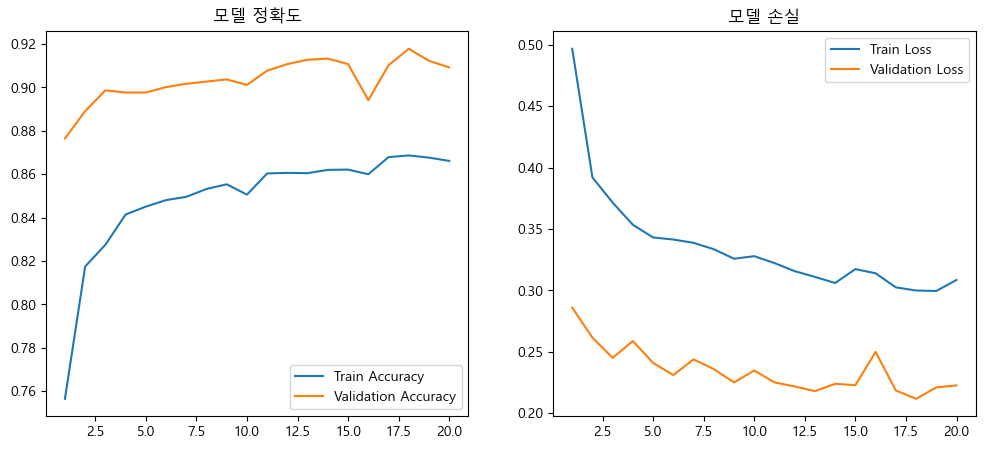

최종 검증 정확도: 0.9093, 최종 검증 손실: 0.2227


In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
fontprop = fm.FontProperties(fname=font_path, size=14)
plt.rc('font', family=fontprop.get_name())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('모델 정확도')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('모델 손실')
plt.legend()

plt.show()

# 최종 성능 출력
final_val_acc = val_acc[-1]
final_val_loss = val_loss[-1]
print(f"최종 검증 정확도: {final_val_acc:.4f}, 최종 검증 손실: {final_val_loss:.4f}")

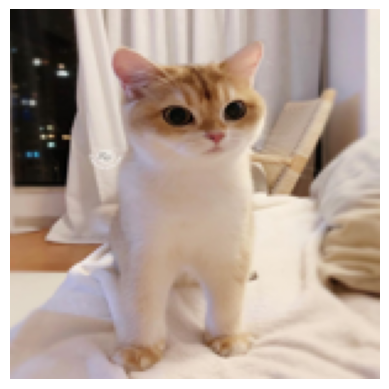

1/1 [==============================] - 0s 430ms/step
모델 예측: 고양이 (확률: 0.9947)


In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

test_image_path = r'C:/Users/PC/Desktop/CNN_Model/example/cat.jpg'

# 2) 이미지 로드 및 전처리 (PIL 사용)
img = Image.open(test_image_path).convert('RGB')
img = img.resize((150, 150))
img_array = np.array(img) / 255.0               # (150, 150, 3)
img_input = np.expand_dims(img_array, axis=0)  # (1, 150, 150, 3)

# 3) 이미지 화면에 표시
plt.imshow(img_array)
plt.axis('off')
plt.show()

# 4) 모델 예측 수행
prediction = model.predict(img_input)

# 5) 결과 출력
if prediction < 0.5:
    print(f"모델 예측: 고양이 (확률: {1 - prediction[0][0]:.4f})")
else:
    print(f"모델 예측: 강아지 (확률: {prediction[0][0]:.4f})")

In [10]:
# 모델 저장
model.save('vgg16_model.keras')

print("모델 저장 완료!")

모델 저장 완료!


Found 2023 images belonging to 2 classes.

✅ 모델 로드 완료

64/64 [==============================] - 55s 859ms/step - loss: 0.2475 - accuracy: 0.9036

[Test set] 손실(loss): 0.2475
[Test set] 정확도(accuracy): 0.9036



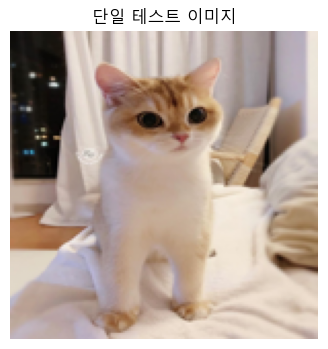

1/1 [==============================] - 0s 154ms/step
단일 이미지 예측 결과 → 고양이 (확률: 0.9947)


🔍 테스트셋 전체 예측을 통한 상세 지표 계산 중...
64/64 [==============================] - 50s 778ms/step
혼동 행렬(Confusion Matrix):
[[881 130]
 [ 65 947]]


Classification Report:
              precision    recall  f1-score   support

        cats       0.93      0.87      0.90      1011
        dogs       0.88      0.94      0.91      1012

    accuracy                           0.90      2023
   macro avg       0.91      0.90      0.90      2023
weighted avg       0.91      0.90      0.90      2023



In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
fontprop = fm.FontProperties(fname=font_path, size=14)
plt.rc('font', family=fontprop.get_name())

test_set_dir = r'C:/Users/PC/Desktop/CNN_Model/dataset/test_set'  # 실제 경로로 수정

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    directory=test_set_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

model_path = r'C:/Users/PC/Desktop/CNN_Model/vgg16_model.keras'  # 실제 모델 파일 경로
loaded_model = load_model(model_path)
print("\n✅ 모델 로드 완료\n")

loss, accuracy = loaded_model.evaluate(test_generator, verbose=1)
print(f"\n[Test set] 손실(loss): {loss:.4f}")
print(f"[Test set] 정확도(accuracy): {accuracy:.4f}\n")

from PIL import Image

# 단일 테스트 이미지 경로 (기존에 사용하던 cat.jpg 같은 파일)
test_image_path = r'C:/Users/PC/Desktop/CNN_Model/example/cat.jpg'

# 1) PIL로 이미지 로드, (150,150) 크기로 Resize, 0~1 정규화
img = Image.open(test_image_path).convert('RGB')
img = img.resize((150, 150))
img_array = np.array(img) / 255.0
img_input = np.expand_dims(img_array, axis=0)  # (1,150,150,3)

# 2) 이미지 화면에 표시
plt.figure(figsize=(4,4))
plt.imshow(img_array)
plt.axis('off')
plt.title("단일 테스트 이미지")
plt.show()

# 3) 예측 수행
single_pred = loaded_model.predict(img_input)
if single_pred < 0.5:
    print(f"단일 이미지 예측 결과 → 고양이 (확률: {1 - single_pred[0][0]:.4f})")
else:
    print(f"단일 이미지 예측 결과 → 강아지 (확률: {single_pred[0][0]:.4f})")
print("\n")

print("🔍 테스트셋 전체 예측을 통한 상세 지표 계산 중...")

# 1) 예측 확률값 얻기
pred_probs = loaded_model.predict(test_generator, verbose=1)  
# pred_probs.shape = (N, 1) 형태, N = 총 테스트 이미지 수

# 2) 확률값을 0/1로 이진 분류 레이블로 변환 (threshold = 0.5)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)  # 0 or 1
true_labels = test_generator.classes                      # 0 or 1

# 3) 클래스 이름 설정 (flow_from_directory 시 자동으로 label 0=cats, 1=dogs 부여됨)
class_names = list(test_generator.class_indices.keys())  
# 예: class_names = ['cats', 'dogs']

# 4) 혼동 행렬(confusion matrix) 출력
cm = confusion_matrix(true_labels, pred_labels)
print("혼동 행렬(Confusion Matrix):")
print(cm)
print("\n")

# 5) 정밀도/재현율/F1-score 등의 지표 출력
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:")
print(report)